# Minimizing Gap Time

In [1]:
# Standard imports
import sys
import os
from itertools import groupby
import json

# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Required imports
from common.sat_gen import make_tle, satellites_from_constellation
from common.station_gen import teleport_json
from common.utils import load_earth_data, gap_times_condense

import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba
import numpy as np
import matplotlib.pyplot as plt

# Pyomo imports
import pyomo.environ as pyo
import pyomo.kernel as pk

%matplotlib inline

# Setup info
load_earth_data('data/iau2000A_finals_ab.txt')

ModuleNotFoundError: No module named 'httpx'

In [8]:
# Create a TLE
epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # Epoch of orbital elements
epc1 = bh.Epoch(2024, 5, 21, 0, 0, 0) # End time for simulation



satellites = satellites_from_constellation('ICEYE')[0:5]

In [9]:
# Load ground stations from JSON file
ground_stations = teleport_json('data/teleport_locations.json')
print(f"Loaded {len(ground_stations)} ground stations")
ground_stations = ground_stations[0:10]

Loaded 915 ground stations


In [10]:
model = pk.block()
# Load original station data from JSON
with open('data/teleport_locations.json', 'r') as f:
    stations_data = json.load(f)

# Get contacts for each station
station_contacts = {}
for i, station in enumerate(ground_stations):
    station_contacts[i] = {
        'contacts': [],
        'station': station,
        'name': stations_data[i]['name']  # Get name from original JSON
    }
    for sat in satellites:
        contacts = ba.find_location_accesses(sat, station, epc0, epc1)
        station_contacts[i]['contacts'].extend(contacts)

# Create binary variables for station selection using kernel interface
model.x = pk.variable_dict()
for i in range(len(ground_stations)):
    model.x[i] = pk.variable(domain=pk.Binary)

# Create constraints list
model.constraints = pk.constraint_list()

# Constraint for exact number of stations
MAX_STATIONS = 5
model.constraints.append(pk.constraint(sum(model.x.values()) == MAX_STATIONS))

# Create variable for total gap time
model.total_gap = pk.variable(domain=pk.NonNegativeReals)

# Create variables for all possible combinations of stations
from itertools import combinations
station_combinations = list(combinations(range(len(ground_stations)), MAX_STATIONS))

# Binary variable for each combination
model.combo_vars = pk.variable_dict()
for combo in station_combinations:
    model.combo_vars[combo] = pk.variable(domain=pk.Binary)

# Only one combination can be selected
model.constraints.append(pk.constraint(sum(model.combo_vars.values()) == 1))

# Link station selection variables with combination variables
for combo in station_combinations:
    # If combo is selected, corresponding stations must be selected
    for i in combo:
        model.constraints.append(pk.constraint(model.x[i] >= model.combo_vars[combo]))
    # If all stations in combo are selected, combo must be selected
    model.constraints.append(
        pk.constraint(sum(model.x[i] for i in combo) - MAX_STATIONS * model.combo_vars[combo] <= MAX_STATIONS - 1)
    )

# Calculate total gap time for each combination using gap_times_condense
total_gap_expr = 0
for combo in station_combinations:
    # Collect all contacts for this combination
    combo_contacts = []
    for sat in satellites:  
        combo_gap = 0
        for station_id in combo:
            contacts = ba.find_location_accesses(sat, station_contacts[station_id]['station'], epc0, epc1)
            combo_contacts.extend(contacts)
        # Use gap_times_condense to calculate gaps
        _, gaps_seconds = gap_times_condense(combo_contacts, epc0.to_datetime(), epc1.to_datetime())
        combo_gap += sum(gaps_seconds)
    
    # Add this combination's contribution to total gap
    total_gap_expr += combo_gap * model.combo_vars[combo]

# Set total gap constraint
model.constraints.append(pk.constraint(model.total_gap == total_gap_expr))

# Create and attach objective to model
model.obj = pk.objective(model.total_gap, sense=pk.minimize)

# Create solver using SolverFactory
from pyomo.opt import SolverFactory
solver = SolverFactory('gurobi')

# Solve
solver.solve(model)

# Print results
selected_stations = []
for i in model.x:
    if model.x[i].value > 0.5:
        selected_stations.append(i)
        print(f"Selected Station {i} ({station_contacts[i]['name']})")

# Calculate and print actual gaps using gap_times_condense
selected_contacts = []
for station_id in selected_stations:
    selected_contacts.extend(station_contacts[station_id]['contacts'])

all_gap_times, gaps_seconds = gap_times_condense(selected_contacts, epc0.to_datetime(), epc1.to_datetime())

print("\nGaps between merged contacts:")
for i, gap_time in enumerate(gaps_seconds):
    print(f"Gap {i+1}: {gap_time:.2f} seconds")

print(f"\nTotal gap time: {sum(gaps_seconds):.2f} seconds")

Selected Station 2 (Planetcast Noida Teleport)
Selected Station 6 (Telstra Gnangara (Perth) Teleport)
Selected Station 7 (Telstra Oxford Falls (Sydney) Australia)
Selected Station 8 (Telstra Stanley Teleport Hong Kong)
Selected Station 9 (A1 Telekom Austria - Aflenz Earth Station)

Gaps between merged contacts:
Gap 1: 754.29 seconds
Gap 2: 94.93 seconds
Gap 3: 74.82 seconds
Gap 4: 2026.87 seconds
Gap 5: 61.35 seconds
Gap 6: 119.07 seconds
Gap 7: 86.19 seconds
Gap 8: 181.24 seconds
Gap 9: 1571.75 seconds
Gap 10: 199.46 seconds
Gap 11: 1913.14 seconds
Gap 12: 1690.77 seconds
Gap 13: 53.11 seconds
Gap 14: 388.50 seconds
Gap 15: 704.46 seconds
Gap 16: 1996.11 seconds
Gap 17: 196.20 seconds
Gap 18: 109.53 seconds
Gap 19: 439.01 seconds
Gap 20: 286.56 seconds
Gap 21: 1390.92 seconds
Gap 22: 360.53 seconds
Gap 23: 306.58 seconds
Gap 24: 332.20 seconds
Gap 25: 35.52 seconds
Gap 26: 1622.37 seconds
Gap 27: 234.46 seconds
Gap 28: 17.23 seconds
Gap 29: 351.30 seconds
Gap 30: 57.68 seconds
Gap 31:

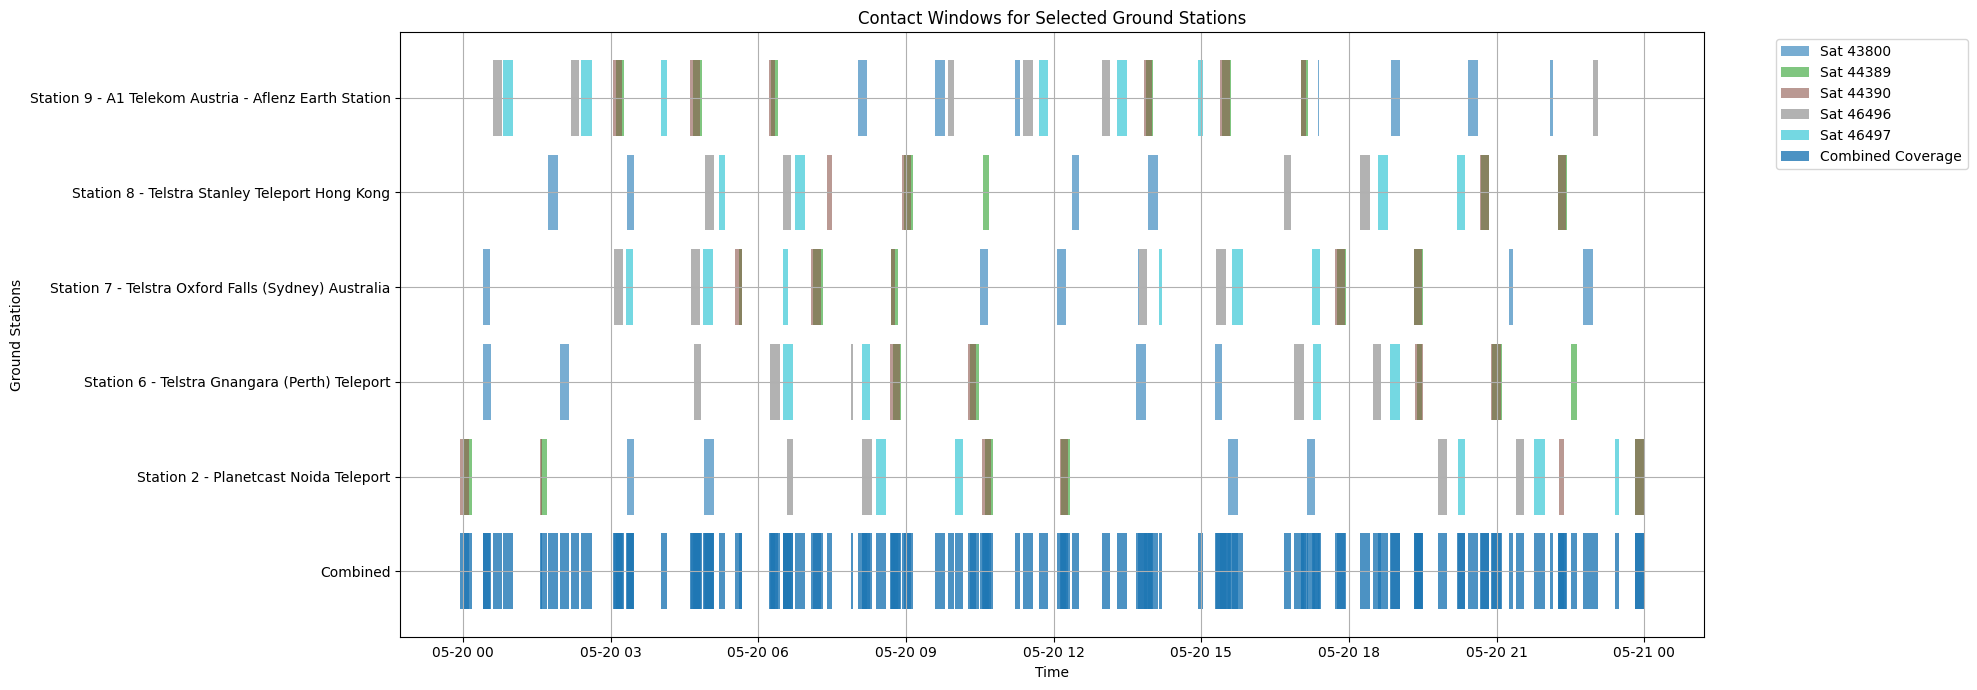

In [11]:
# Update the visualization cell:
# Create visualization
fig, ax = plt.subplots(figsize=(20,7))

# Plot contacts for individual selected stations
colors = plt.cm.tab10(np.linspace(0, 1, len(satellites)))  # Create color map for satellites
for idx, station_id in enumerate(selected_stations):
    contacts = station_contacts[station_id]['contacts']
    station_name = station_contacts[station_id]['name']
    
    # Group contacts by satellite
    for sat_idx, sat in enumerate(satellites):
        sat_contacts = [c for c in contacts if c.spacecraft_id == sat.id]
        if sat_contacts:
            ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start) 
                        for contact in sat_contacts],
                        (idx + 1, 0.8),  # Shifted up by 1 to make room for combined view
                        facecolors=colors[sat_idx],
                        alpha=0.6,
                        label=f'Sat {sat.id}' if idx == 0 else "")

# Plot combined contacts at the bottom
selected_contacts = []
for station_id in selected_stations:
    selected_contacts.extend(station_contacts[station_id]['contacts'])

# Sort contacts by start time
sorted_contacts = sorted(selected_contacts, key=lambda x: x.t_start)

# Plot the actual contact windows for combined view
ax.broken_barh([(contact.t_start, contact.t_end-contact.t_start) 
                for contact in sorted_contacts],
                (0, 0.8),  # At the bottom
                facecolors='tab:blue',  # Single solid color
                alpha=0.8,
                label='Combined Coverage')

# Update y-axis ticks with station ID and name
ax.set_yticks([0.4] + [i + 1.4 for i in range(len(selected_stations))])
ax.set_yticklabels(['Combined'] + [f'Station {sid} - {station_contacts[sid]["name"]}' 
                                  for sid in selected_stations])

plt.ylabel("Ground Stations")
plt.xlabel("Time")
plt.title("Contact Windows for Selected Ground Stations")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()